In [1]:
from ipynb.fs.full.functions import getPatientData, getCancerPixels, getCombinedCancerMask

import matplotlib.pyplot as plt
import scipy.stats
import numpy as np

In [2]:
[patients, numPatients, numPatientsWithTumor] = getPatientData()
patients = [item for item in patients if item["patientID"] != "P00000249"]

In [3]:
adcCancerPixels,    cdiCancerPixels    = np.array([]), np.array([])
adcNonCancerPixels, cdiNonCancerPixels = np.array([]), np.array([])

for patient in patients:
    if patient["numTumor"] != 0:
        cancerPixelsTmp = getCancerPixels(patient,"adc",True)
        adcCancerPixels = np.append(adcCancerPixels, cancerPixelsTmp)
        cancerPixelsTmp = getCancerPixels(patient,"cdi",True)
        cdiCancerPixels = np.append(cdiCancerPixels, cancerPixelsTmp)
    nonCancerPixelsTmp = getCancerPixels(patient,"adc",False)
    adcNonCancerPixels = np.append(adcNonCancerPixels, nonCancerPixelsTmp)
    nonCancerPixelsTmp = getCancerPixels(patient,"cdi",False)
    cdiNonCancerPixels = np.append(cdiNonCancerPixels, nonCancerPixelsTmp)

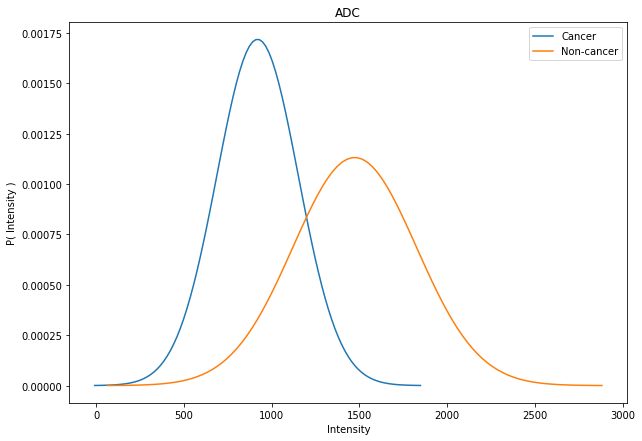

In [4]:
dist = scipy.stats.norm

mu_adc_cancer,     std_adc_cancer     = dist.fit(adcCancerPixels)
mu_adc_non_cancer, std_adc_non_cancer = dist.fit(adcNonCancerPixels)

x_adc_cancer     = np.linspace(mu_adc_cancer    -4*std_adc_cancer,    mu_adc_cancer    +4*std_adc_cancer,    100)
x_adc_non_cancer = np.linspace(mu_adc_non_cancer-4*std_adc_non_cancer,mu_adc_non_cancer+4*std_adc_non_cancer,100)

y_adc_cancer     = dist.pdf(x_adc_cancer,    mu_adc_cancer,    std_adc_cancer)
y_adc_non_cancer = dist.pdf(x_adc_non_cancer,mu_adc_non_cancer,std_adc_non_cancer)

plt.figure(figsize=(10,7))
plt.plot(x_adc_cancer,    y_adc_cancer)
plt.plot(x_adc_non_cancer,y_adc_non_cancer)
plt.title("ADC")
plt.xlabel("Intensity")
plt.ylabel("P( Intensity )")
plt.legend(["Cancer","Non-cancer"])
plt.show()

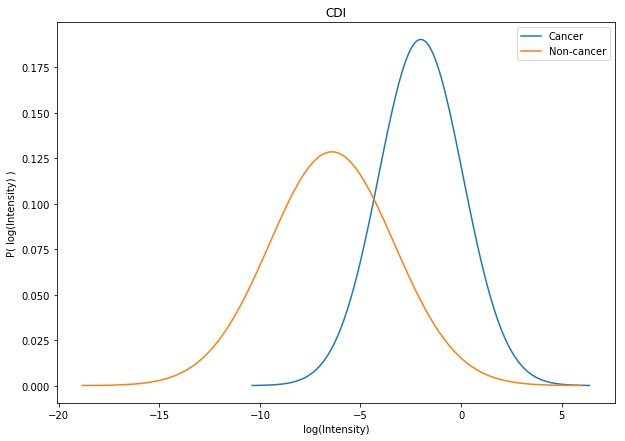

In [5]:
dist = scipy.stats.norm

mu_cdi_cancer,     std_cdi_cancer     = dist.fit(np.log(cdiCancerPixels[cdiCancerPixels>0]))
mu_cdi_non_cancer, std_cdi_non_cancer = dist.fit(np.log(cdiNonCancerPixels[cdiNonCancerPixels>0]))

x_cdi_cancer     = np.linspace(mu_cdi_cancer    -4*std_cdi_cancer,    mu_cdi_cancer    +4*std_cdi_cancer,    100)
x_cdi_non_cancer = np.linspace(mu_cdi_non_cancer-4*std_cdi_non_cancer,mu_cdi_non_cancer+4*std_cdi_non_cancer,100)

y_cdi_cancer     = dist.pdf(x_cdi_cancer,    mu_cdi_cancer,    std_cdi_cancer)
y_cdi_non_cancer = dist.pdf(x_cdi_non_cancer,mu_cdi_non_cancer,std_cdi_non_cancer)

plt.figure(figsize=(10,7))
plt.plot(x_cdi_cancer,    y_cdi_cancer)
plt.plot(x_cdi_non_cancer,y_cdi_non_cancer)
plt.title("CDI")
plt.xlabel("log(Intensity)")
plt.ylabel("P( log(Intensity) )")
plt.legend(["Cancer","Non-cancer"])
plt.show()

### Confusion Matrix